In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Flatten,Input
import matplotlib.pyplot as plt
from keras.layers import LSTM,Dense,Dropout,MaxPooling1D,TimeDistributed,Conv1D
from keras.models import load_model
from keras.models import Model


Using TensorFlow backend.


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv('Pepsico.csv')
df['date'] = pd.to_datetime(df['date'])


df.set_index('date', inplace=True)
print(df[:3])

            close    volume   open   high    low
date                                            
2009-07-06  57.13   8886559  56.27  57.17  56.08
2009-07-07  56.00  11953480  57.07  57.46  55.92
2009-07-08  54.85  12089730  56.09  56.13  54.52


In [4]:
look_back = 20
def processData(data, look_back):
    X,y = [],[]
    for i in range(look_back,len(data)):
        #X will contain 5 features from day i-N to day i-1
        #y will be closing price on day i
        X.append(data[i-look_back:i].values)
        y.append(data.iat[i,0])
        #Feature scaling
    X= np.array(X)
    y=np.array(y)
    scl = MinMaxScaler()

    y = scl.fit_transform(y.reshape(-1,1))
    for i in range(X.shape[2]):
        X[:,:,i] = scl.fit_transform(X[:,:,i])
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle = False)
    return X_train,X_test,y_train,y_test

In [5]:
def get_accuracy(y_pred,y_test):
    #Constructing predicted movement
    movement_pred = pd.DataFrame(y_pred) - pd.DataFrame(y_pred).shift()
    movement_pred.dropna(inplace = True)
    for i in range(len(movement_pred)):
        if movement_pred.iat[i,0] > 0:
            movement_pred.iat[i,0] = 1
        else:
            movement_pred.iat[i,0] = 0
    #Constructing groundtruth movement
    movement_gt = pd.DataFrame(y_test) - pd.DataFrame(y_test).shift()
    movement_gt.dropna(inplace = True)
    for i in range(len(movement_gt)):
        if movement_gt.iat[i,0] > 0:
            movement_gt.iat[i,0] = 1
        else:
            movement_gt.iat[i,0] = 0
    #Make a comparison then calculate accuracy
    movement = (movement_pred==movement_gt)
    accuracy = np.unique(movement, return_counts=True)[1][1] / len(movement)
    
    #Calculating RMSE and MAPE
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)
    z = pd.DataFrame(np.abs((y_test - y_pred)/y_test)).replace(np.inf, np.nan)
    MAPE = z.mean() * 100
    
    RMSE = math.sqrt(mean_squared_error(y_pred,y_test))
    
    return accuracy,MAPE,RMSE


In [6]:
weight_decay = 1e-3
from keras.regularizers import l2
from keras import regularizers, initializers, optimizers 

In [7]:
#Constructing Conv1D - LSTM model
input_layer = Input(shape=(look_back, 5))
x = Conv1D(filters=80,
                   kernel_size=1,
                   strides=1,
                   activation='relu',padding='same',kernel_regularizer=l2(weight_decay),kernel_initializer=initializers.he_normal(seed=0))(input_layer)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(filters=48,
                   kernel_size=1,
                   strides=1,
                   activation='relu',padding='same',kernel_regularizer=l2(weight_decay),kernel_initializer=initializers.he_normal(seed=0))(x)
x = MaxPooling1D(pool_size=2)(x)

x = Dropout(0.5)(x)

x = LSTM(128,return_sequences = True,kernel_regularizer=l2(weight_decay),kernel_initializer=initializers.he_normal(seed=0))(x)
x = Dropout(0.5)(x)
   
x = LSTM(32,return_sequences = False,kernel_regularizer=l2(weight_decay),kernel_initializer=initializers.he_normal(seed=0))(x)
x = Dropout(0.5)(x)
x = Dense(16,activation='relu')(x)
output_layer = Dense(1,activation='linear')(x)
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='rmsprop', loss='mean_squared_error')
model.summary()
    

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20, 5)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 80)            480       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 80)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 48)            3888      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 5, 48)             0         
_________________________________________________________________
dropout_1 (Dropout)  

In [11]:
#Employing reduce learning rate strategy
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=0, min_lr=1e-5)

# PEPSICO CNN LSTM

In [12]:
X_train,X_test,y_train,y_test = processData(df,look_back)

In [13]:
model.fit(X_train,y_train,batch_size = 16,epochs = 30,validation_split=0.3,callbacks=[reduce_lr] )

Instructions for updating:
Use tf.cast instead.
Train on 1398 samples, validate on 600 samples
Epoch 1/30
1398/1398 [==============================] - 3s 2ms/step - loss: 0.5505 - val_loss: 0.4245
Epoch 2/30
1398/1398 [==============================] - 1s 656us/step - loss: 0.3298 - val_loss: 0.2703
Epoch 3/30
1398/1398 [==============================] - 1s 649us/step - loss: 0.1984 - val_loss: 0.1539
Epoch 4/30
1398/1398 [==============================] - 1s 578us/step - loss: 0.1255 - val_loss: 0.0999
Epoch 5/30
1398/1398 [==============================] - 1s 977us/step - loss: 0.0853 - val_loss: 0.1196
Epoch 6/30
1398/1398 [==============================] - 1s 772us/step - loss: 0.0616 - val_loss: 0.0682
Epoch 7/30
1398/1398 [==============================] - 1s 629us/step - loss: 0.0451 - val_loss: 0.0366
Epoch 8/30
1398/1398 [==============================] - 1s 636us/step - loss: 0.0331 - val_loss: 0.0352
Epoch 9/30
1398/1398 [==============================] - 1s 601us/step - los

In [14]:
y_pred = model.predict(X_test)

In [15]:
acc1,MAPE1,RMSE1=get_accuracy(y_pred,y_test)
print('RMSE %2f' %(RMSE1))
print('MAPE %2f' %(MAPE1))
print('Accuracy %2f' %(acc1))

RMSE 0.147131
MAPE 17.307806
Accuracy 0.533066


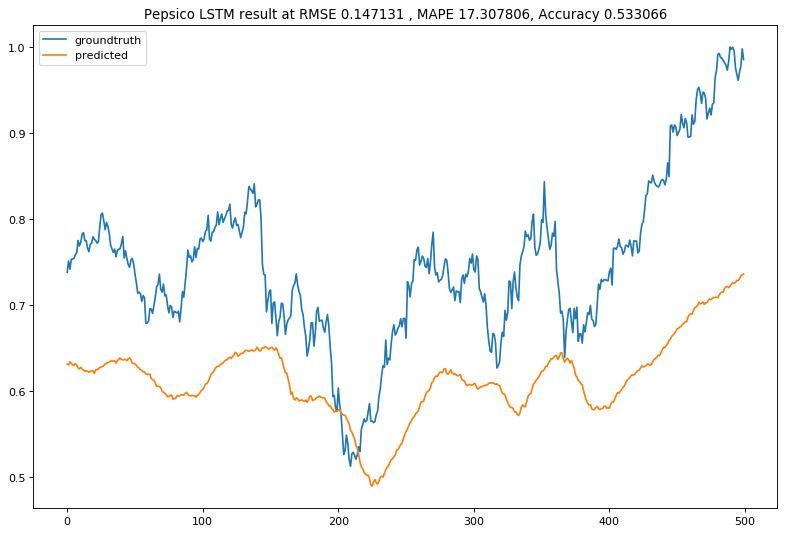

In [16]:
plt.figure(figsize=(12, 8), dpi=80)
plt.title('Pepsico LSTM result at RMSE %2f , MAPE %2f, Accuracy %2f' %(RMSE1,MAPE1,acc1))
plt.plot(y_test,label = 'groundtruth')
plt.plot(y_pred,label='predicted')
plt.legend()

# ALIBABA CNN LSTM

In [17]:
df2 = pd.read_csv('Alibaba.csv')
df2['date'] = pd.to_datetime(df2['date'])

#keep only the 'Close' column
#df=pd.DataFrame(df[['date','close']])
df2.set_index('date', inplace=True)
print(df2[:3])

            close     volume   open   high    low
date                                             
2014-09-19  93.89  271718000  92.70  99.70  89.95
2014-09-22  89.89   66495310  92.70  92.95  89.50
2014-09-23  87.17   38935050  88.94  90.48  86.62


In [18]:
X_train2,X_test2,y_train2,y_test2 = processData(df2,look_back)

In [19]:
model.fit(X_train2,y_train2,batch_size = 16,epochs = 30,validation_split=0.3,callbacks=[reduce_lr] )

Train on 663 samples, validate on 285 samples
Epoch 1/30
663/663 [==============================] - 0s 582us/step - loss: 0.0046 - val_loss: 0.0311
Epoch 2/30
663/663 [==============================] - 0s 617us/step - loss: 0.0045 - val_loss: 0.0314
Epoch 3/30
663/663 [==============================] - 0s 696us/step - loss: 0.0046 - val_loss: 0.0333
Epoch 4/30
663/663 [==============================] - 0s 728us/step - loss: 0.0045 - val_loss: 0.0342
Epoch 5/30
663/663 [==============================] - 0s 671us/step - loss: 0.0044 - val_loss: 0.0351
Epoch 6/30
663/663 [==============================] - 0s 675us/step - loss: 0.0045 - val_loss: 0.0360
Epoch 7/30
663/663 [==============================] - 0s 699us/step - loss: 0.0045 - val_loss: 0.0385
Epoch 8/30
663/663 [==============================] - 0s 648us/step - loss: 0.0045 - val_loss: 0.0396
Epoch 9/30
663/663 [==============================] - 0s 716us/step - loss: 0.0046 - val_loss: 0.0390
Epoch 10/30
663/663 [===============

In [20]:
y_pred2 = model.predict(X_test2)
acc2,MAPE2,RMSE2=get_accuracy(y_pred2,y_test2)
print('RMSE %2f' %(RMSE2))
print('MAPE %2f' %(MAPE2))
print('Accuracy %2f' %(acc2))

RMSE 0.150090
MAPE 17.954070
Accuracy 0.540084


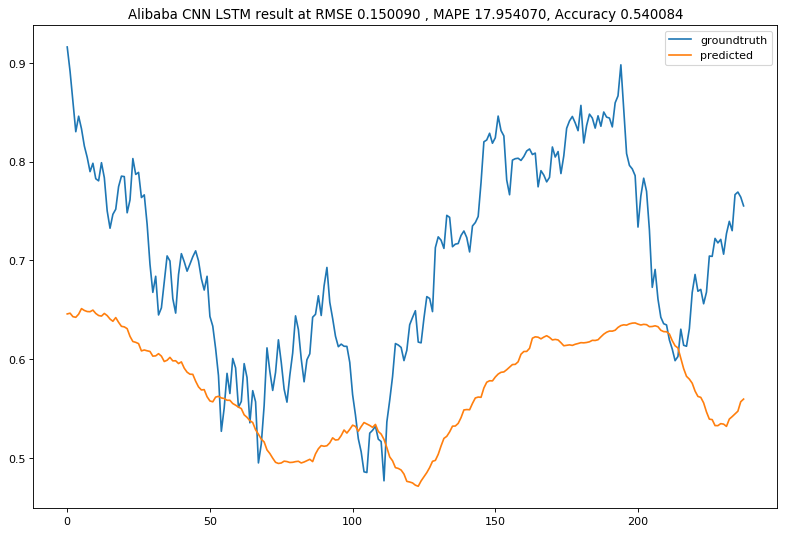

In [27]:
plt.figure(figsize=(12, 8), dpi=80)
plt.title('Alibaba CNN LSTM result at RMSE %2f , MAPE %2f, Accuracy %2f' %(RMSE2,MAPE2,acc2))
plt.plot(y_test2,label = 'groundtruth')
plt.plot(y_pred2,label='predicted')
plt.legend()

# VINGROUP CNN LSTM 

In [22]:
df3 = pd.read_csv('VinGroup.csv')
df3['date'] = pd.to_datetime(df3['date'])

#keep only the 'Close' column
#df=pd.DataFrame(df[['date','close']])
df3.set_index('date', inplace=True)
print(df3[:3])

            close  volume   open   high    low
date                                          
2009-07-07  116.7  307400  116.0  116.8  115.8
2009-07-08  116.5  265260  115.0  116.5  115.0
2009-07-09  115.4  260170  115.5  116.0  114.3


In [23]:
X_train3,X_test3,y_train3,y_test3 = processData(df3,look_back)

In [24]:
model.fit(X_train3,y_train3,batch_size = 16,epochs = 30,validation_split=0.3,callbacks=[reduce_lr] )

Train on 1384 samples, validate on 594 samples
Epoch 1/30
1384/1384 [==============================] - 1s 807us/step - loss: 0.0132 - val_loss: 0.0103
Epoch 2/30
1384/1384 [==============================] - 1s 677us/step - loss: 0.0119 - val_loss: 0.0093
Epoch 3/30
1384/1384 [==============================] - 1s 709us/step - loss: 0.0116 - val_loss: 0.0085
Epoch 4/30
1384/1384 [==============================] - 1s 713us/step - loss: 0.0115 - val_loss: 0.0083
Epoch 5/30
1384/1384 [==============================] - 1s 690us/step - loss: 0.0123 - val_loss: 0.0081
Epoch 6/30
1384/1384 [==============================] - 1s 677us/step - loss: 0.0113 - val_loss: 0.0081
Epoch 7/30
1384/1384 [==============================] - 1s 695us/step - loss: 0.0120 - val_loss: 0.0081
Epoch 8/30
1384/1384 [==============================] - 1s 659us/step - loss: 0.0114 - val_loss: 0.0080
Epoch 9/30
1384/1384 [==============================] - 1s 677us/step - loss: 0.0115 - val_loss: 0.0078
Epoch 10/30
1384/

In [25]:
y_pred3 = model.predict(X_test3)
acc3,MAPE3,RMSE3=get_accuracy(y_pred3,y_test3)
print('RMSE %2f' %(RMSE3))
print('MAPE %2f' %(MAPE3))
print('Accuracy %2f' %(acc3))

RMSE 0.114280
MAPE 25.180057
Accuracy 0.550607


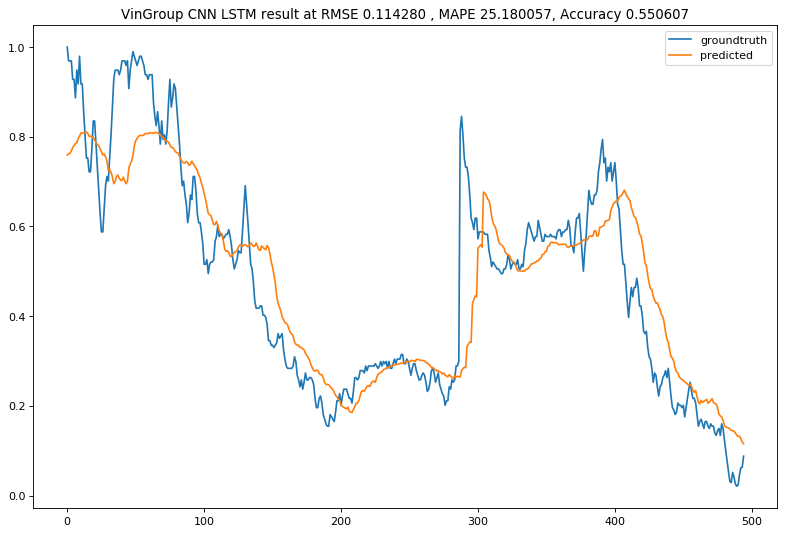

In [26]:
plt.figure(figsize=(12, 8), dpi=80)
plt.title('VinGroup CNN LSTM result at RMSE %2f , MAPE %2f, Accuracy %2f' %(RMSE3,MAPE3,acc3))
plt.plot(y_test3,label = 'groundtruth')
plt.plot(y_pred3,label='predicted')
plt.legend()